## Phase behavior of single component Lennard-Jones

In [20]:
import numpy as np
import pandas as pd
import rumdpy as rp
import numba
from rumdpy.visualization import k3d_Visualization

import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

## Generate configuration with a FCC lattice

In [29]:
conf = rp.Configuration(D=3)
conf.make_lattice(unit_cell=rp.unit_cells.FCC, cells=(6,12,6), rho=0.6)
conf['m'] = 1
conf.randomize_velocities(T=2.0)
print(f'Number of particles: {conf.N}; Density: {conf.N/conf.get_volume():.3f}')

Number of particles: 1728; Density: 0.600


## Setup interactions: Lennard-Jones pair potential

In [30]:
pair_func = rp.apply_shifted_potential_cutoff(rp.LJ_12_6_sigma_epsilon)
sigma, epsilon, cutoff = 1.0, 1.0, 2.5
pair_pot = rp.PairPotential(pair_func, params=[sigma, epsilon, cutoff], max_num_nbs=1000)

## Setup integrator with temperature ramp

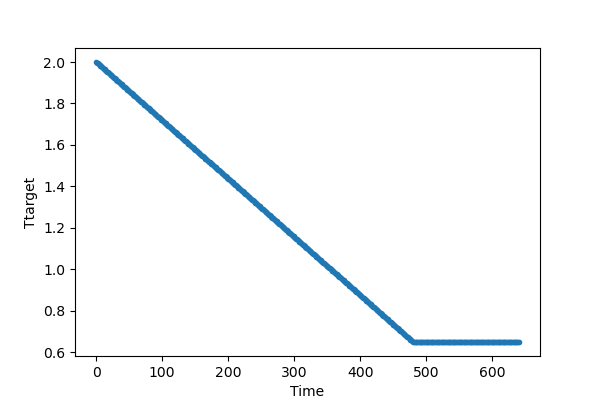

In [36]:
dt = 0.005              # Duration of timestep 
num_blocks = 500        # Do simulation in this many 'blocks'
steps_per_block = 256  # ... each of this many timesteps
running_time = dt*num_blocks*steps_per_block

Ttarget_function = rp.make_function_ramp(value0=2.00, x0=running_time*(0/4), 
                                         value1=0.65, x1=running_time*(3/4))
integrator = rp.integrators.NVT(Ttarget_function, tau=0.2, dt=dt)

plt.figure(figsize=(6,4))
t = np.linspace(0,running_time,num_blocks)
plt.plot(t, numba.vectorize(Ttarget_function)(t), '.-')
plt.xlabel('Time')
plt.ylabel('Ttarget')
plt.show()

## Setup simulation

In [37]:
sim = rp.Simulation(conf, pair_pot, integrator,
                    num_timeblocks=num_blocks, steps_per_timeblock=steps_per_block,
                    steps_between_momentum_reset=300,
                    storage='memory')

## Setup 3D visualization

In [38]:
from rumdpy.visualization import k3d_Visualization

viz = k3d_Visualization(sim)
viz.display()

Output()

## Run simulation with 3D visualization

In [39]:
for block in sim.timeblocks():
    viz.update(block, choice=0)
viz.display_player()
print(sim.summary())

Particles : 1728 
Steps : 128000 
nbflag : [    0     0 10865] 
Total time (incl. time spent between blocks): 6.66 s 
Simulation time : 5.11 s 
Extra time 1.st block (presumably JIT): 0.00 s 
TPS_total : 1.92e+04 
TPS_sim : 2.50e+04 
TPS_sim_minus_extra : 2.51e+04 



## Plotting potential energy during cooling

In [35]:
columns = ['U', 'W', 'lapU', 'Fsq', 'K', 'Vol', 'Px', 'Py', 'Pz']
data = np.array(rp.extract_scalars(sim.output, columns, first_block=1))
df = pd.DataFrame(data.T, columns=columns)
df['t'] = np.arange(len(df['U'])) * dt * sim.output.attrs["steps_between_output"]  # should be build in
if callable(Ttarget_function):
    df['Ttarget'] = numba.vectorize(Ttarget_function)(np.array(df['t']))
df['P'] = (conf.N*df['Ttarget'] + df['W']) /conf.get_volume()

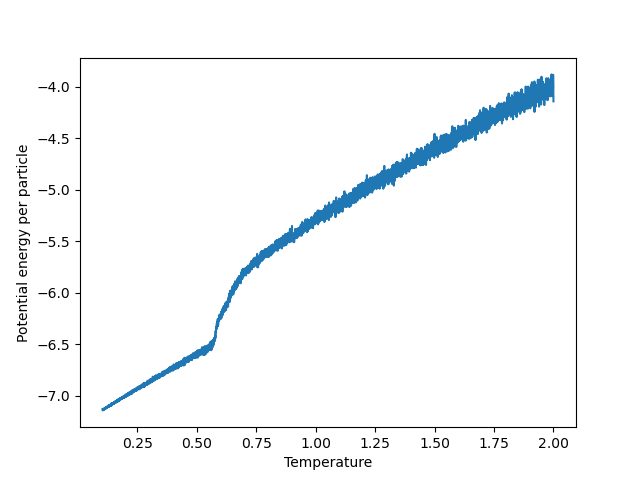

In [28]:
plt.figure()
plt.plot(df['Ttarget'], df['U']/conf.N)
plt.xlabel('Temperature')
plt.ylabel('Potential energy per particle')
plt.show()